# Install Segment Anything

In [1]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\david\appdata\local\temp\pip-req-build-tqlhp0ha
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\david\AppData\Local\Temp\pip-req-build-tqlhp0ha'

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision

In [3]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())


PyTorch version: 2.1.1+cu118
Torchvision version: 0.16.1+cu118
CUDA is available: True


In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [5]:
image = cv2.imread('images/57260-768.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

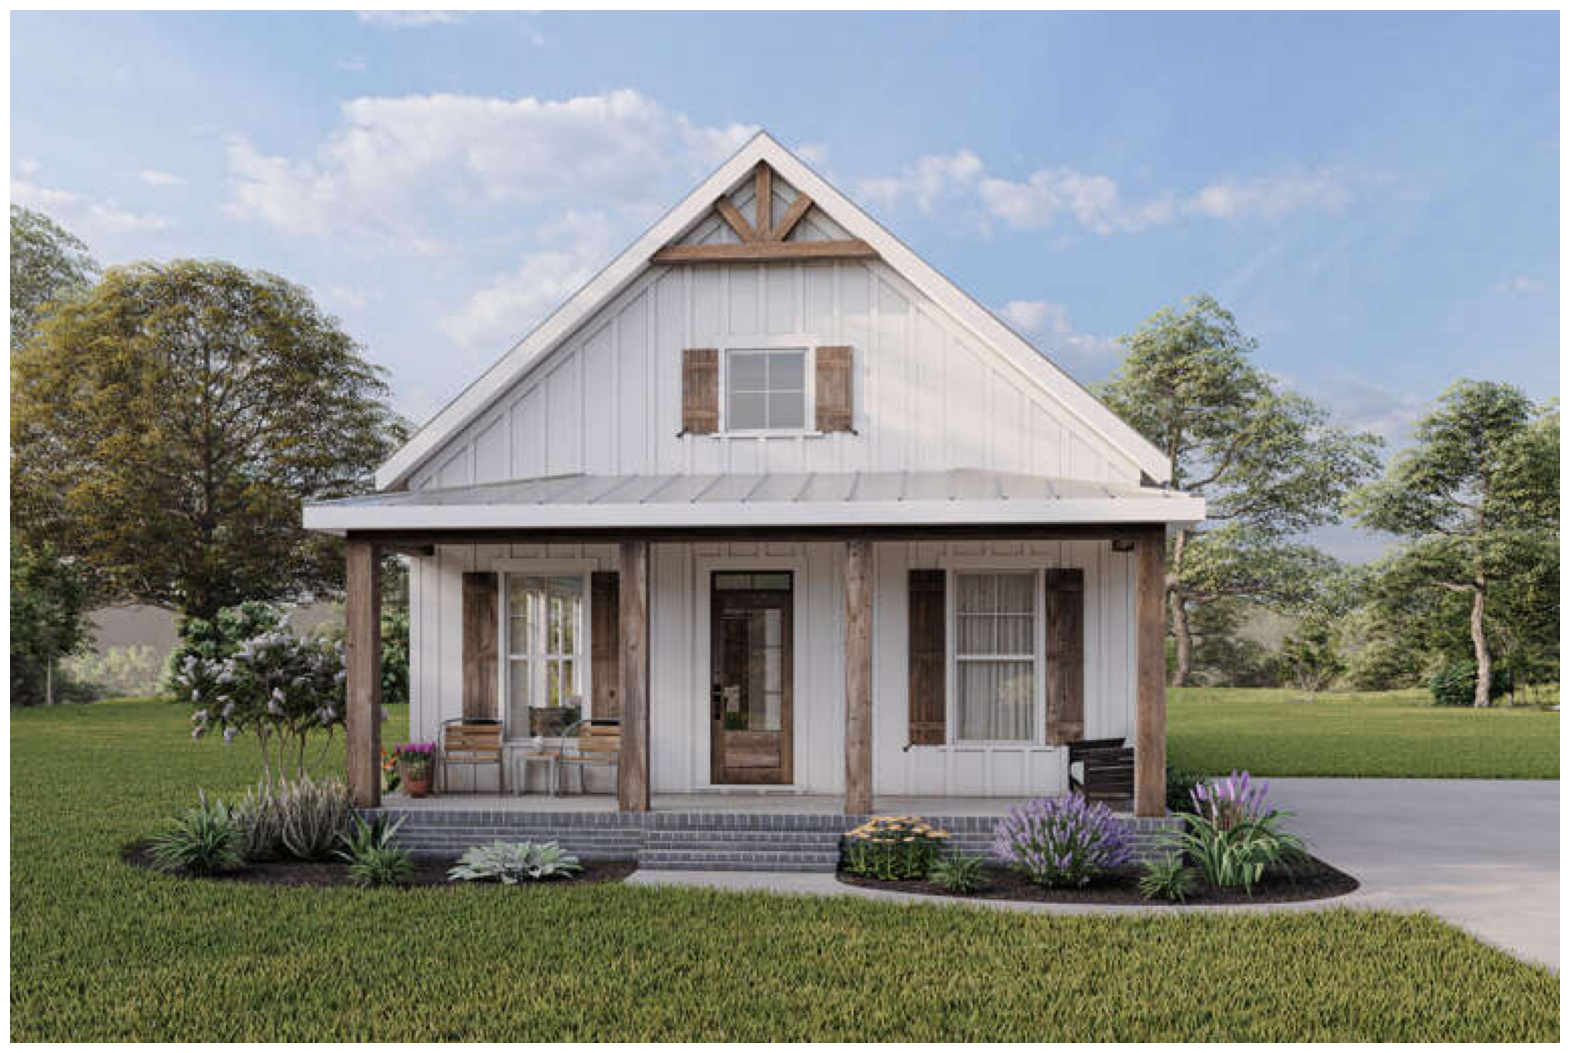

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [47]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [10]:
masks = mask_generator.generate(image)

In [48]:
masks2 = mask_generator_2.generate(image)

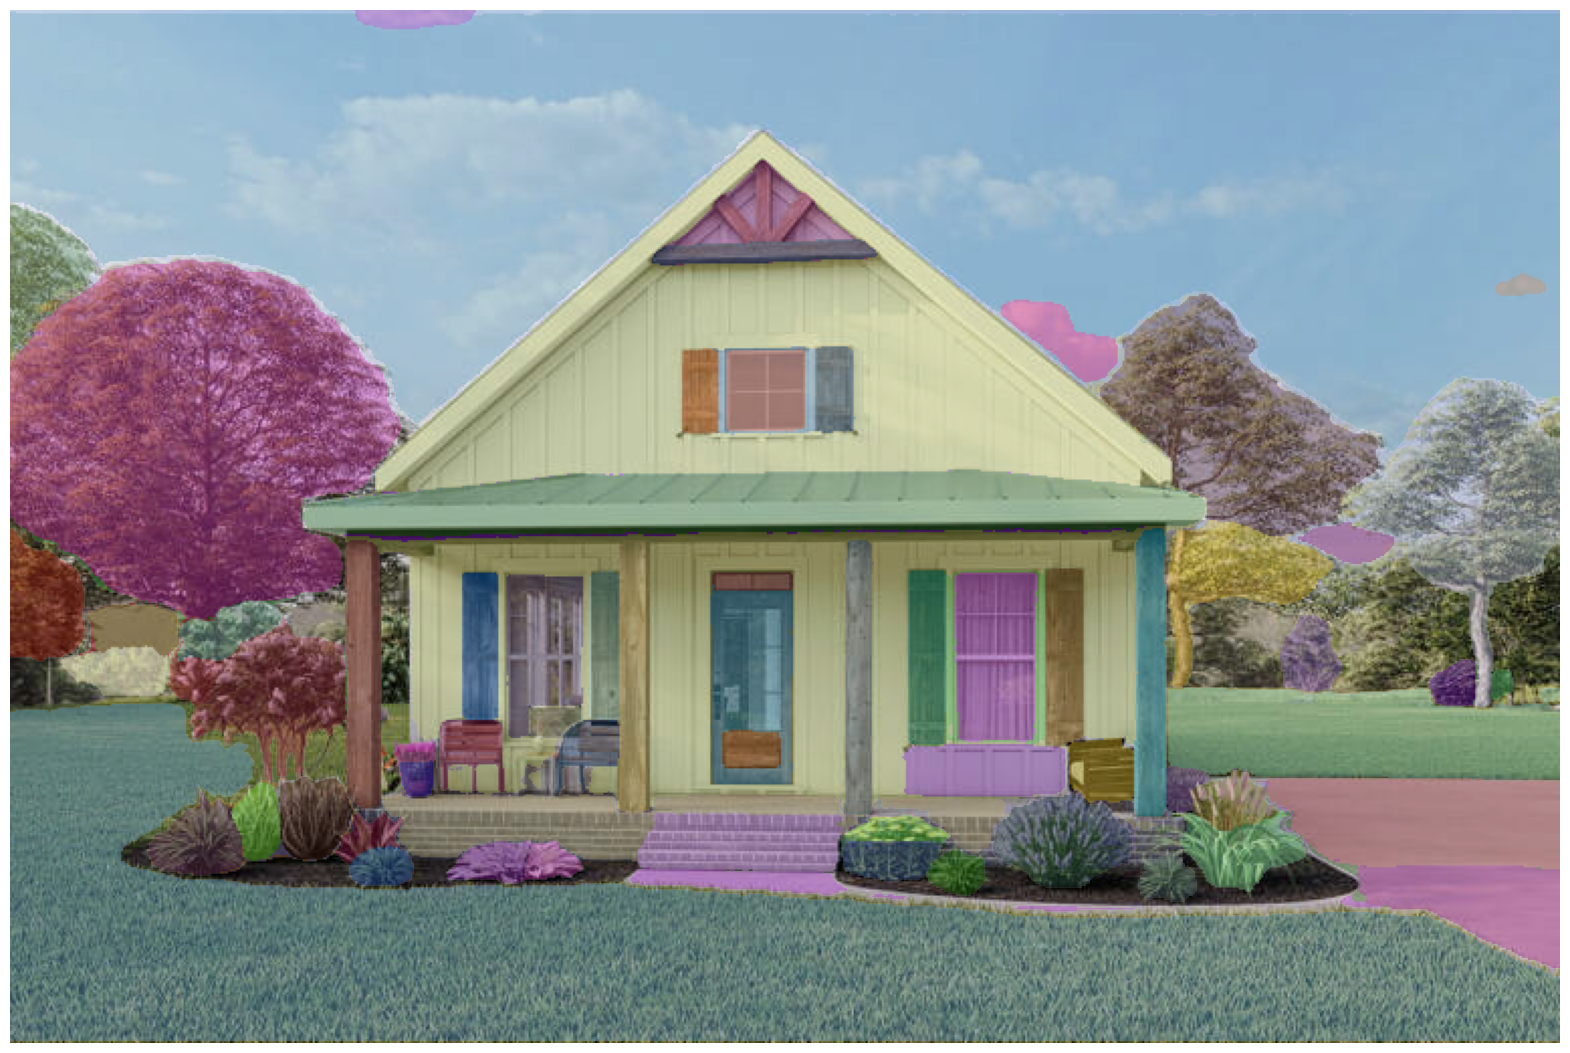

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
#plt.savefig('mask_images/masks_with_defaults.png') 
plt.show()

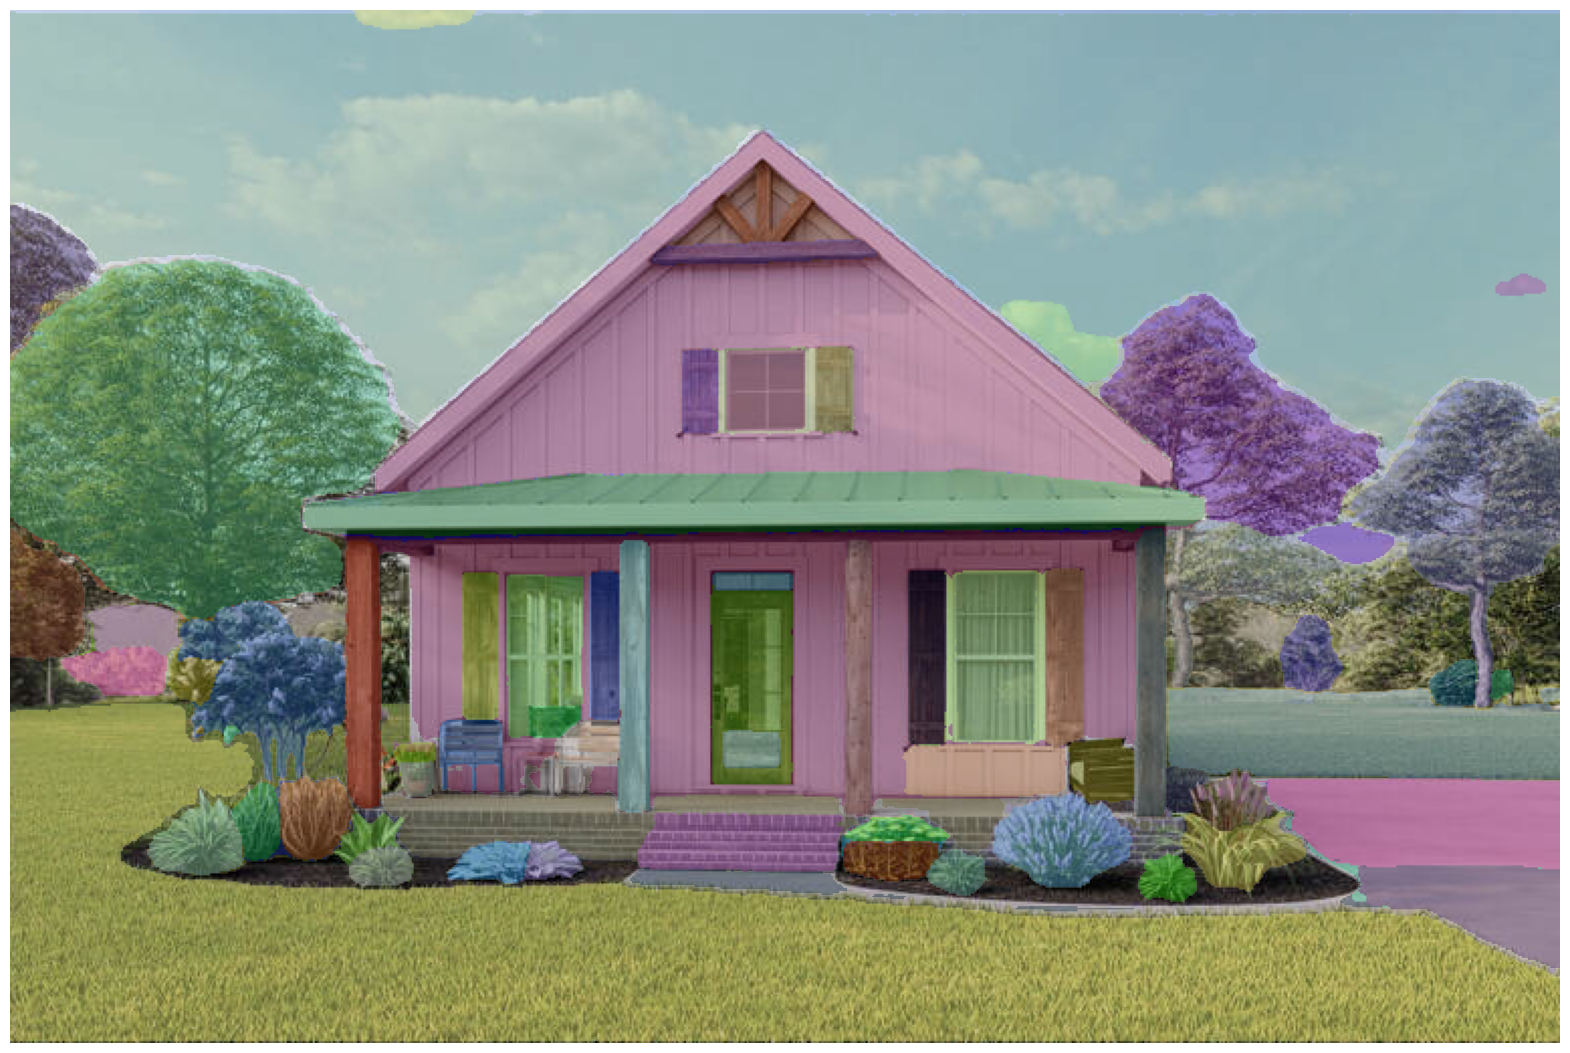

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
#plt.savefig('mask_images/masks_with_defaults.png') 
plt.show()

In [14]:
print("Number of Masks: " , len(masks))
print(masks[0].keys())
print(masks[0]['bbox'])

Number of Masks:  77
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
[0, 344, 767, 166]


In [14]:
# Save all masks
import os
for i in range(len(masks)):
    x, y, width, height = masks[i]['bbox']
    cropped_image = image[int(y):int(y+height), int(x):int(x+width)]
    filename = os.path.join('mask_images/', str(i) + '.png')
    cv2.imwrite(filename, cropped_image)

In [23]:
from matplotlib.patches import Polygon

# Function to check if a point is inside a bounding box
def point_inside_bbox(point, bbox):
    x, y = point
    xmin, ymin, xmax, ymax = bbox
    print(xmin, ymin, xmax, ymax)
    return xmin <= x <= xmax and ymin <= y <= ymax

# Function to find the mask containing the given coordinates
def find_mask(coord):
    masks = mask_generator.generate(image)
    for i, masks in enumerate(masks, start=2):
        if point_inside_bbox(coord, masks['bbox']):
            return i
    return None

sample_coord = (0,344)
sample_bbox = [0,0,1000,1000]

print(point_inside_bbox(sample_coord, masks[0]['bbox']))

0 344 767 166
False


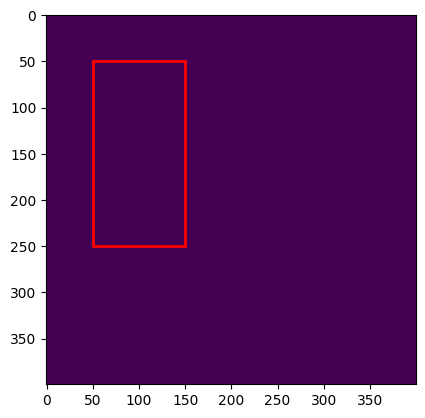

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sample bounding box in XYWH format
bbox = [50, 50, 100, 200]  # x, y, width, height

# Create a figure and axis
fig, ax = plt.subplots()

# Example background image (replace with your own image)
ax.imshow(np.zeros((400, 400)))

# Add rectangle for bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='r', facecolor='none', linewidth=2)
ax.add_patch(rect)

plt.show()
